In [1]:
import random

import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import tengp
from gpbenchmarks import get_data


def pdivide(x, y):
    return np.divide(x, y, out=np.copy(x), where=x!=0)

def plog(x, y):
    return np.log(x, out=np.copy(x), where=x>0)

def psin(x, y):
    return np.sin(x)

def pcos(x, y):
    return np.cos(x)

def pow2(x, y):
    return x**2

def pow3(x, y):
    return x**3

def ptan(x, y):
    return np.tan(x)

def ptanh(x, y):
    return np.tanh(x)

def psqrt(x, y):
    return  np.sqrt(x)

def pexp(x, y):
    return np.exp(x)


funset = tengp.FunctionSet()
funset.add(np.add, 2)
funset.add(np.subtract, 2)
funset.add(np.multiply, 2)
funset.add(pdivide, 2)
funset.add(plog, 2)
funset.add(psin, 2)
funset.add(pcos, 2)

#     function set: +, -, *, /, sin, cos, tan, tanh, sqrt, exp, log, **2, **3
ext_funset = tengp.FunctionSet()
ext_funset.add(np.add, 2)
ext_funset.add(np.subtract, 2)
ext_funset.add(np.multiply, 2)
ext_funset.add(pdivide, 2)
ext_funset.add(psin, 2)
ext_funset.add(pcos, 2)
ext_funset.add(ptan, 2)
ext_funset.add(ptanh, 2)
ext_funset.add(psqrt, 2)
ext_funset.add(pexp, 2)
ext_funset.add(plog, 2)
ext_funset.add(pow2, 2)
ext_funset.add(pow3, 2)

def sfn(c):
    return (np.sin(2 * np.pi * (c - 1/4)) + 1)/2

params1d = tengp.Parameters(2, 1, 1, 40, funset, real_valued=True, smoothing_fn=sfn)
params2d = tengp.Parameters(3, 1, 1, 40, funset, real_valued=True, smoothing_fn=sfn)
params5d = tengp.Parameters(6, 1, 1, 40, ext_funset, real_valued=True, smoothing_fn=sfn)

functions = [('nguyenf4', params1d, [20, -1, 1]), ('nguyenf7', params1d, [20, 0, 2]), ('nguyenf10', params2d, [100, -1, 1]), ('korns12', params5d, [10000, -50, 50])]

In [2]:
trials = 10

In [3]:
# def cost_function(params, bounds, y, X, G):
#     clipped = []
#     for gene, bound in zip(G, bounds):
#         if gene < 0:
#             clipped.append(0)
#         elif gene > bound:
#             clipped.append(bound)
#         else:
#             clipped.append(gene)

#     individual = tengp.individual.NPIndividual(clipped, bounds, params)
#     pred = individual.transform(X)

#     try:
#         out = mean_squared_error(pred, y)
#     except ValueError:
#         out = np.inf
#     return (out, )
def scale_a(x, a, b):
    return a + (b - a) * x / 10

def scale_b(x, a, b):
    return a + (b - a) * (x/10)**2

def scale_c(x, a, b):
    return a *(b/a)**(x/10)

import math

def bound(x, a, b):
    return a + (b - a) * ( 1 - np.cos(np.pi * x/10))/2

def cost_function(params, bounds, y, X, rv_genes):
    bounded = bound(np.array(rv_genes), 0, 10)
    scaled = [scale_b(x, 0, b) for x, b in zip(bounded, bounds)]
    
    individual = tengp.individual.NPIndividual(scaled, bounds, params)
    pred = individual.transform(X)
    
    try:
        out = mean_squared_error(pred, y)
    except ValueError:
        out = np.inf
    return (out, )

In [4]:
from deap import creator, base, tools, cma, algorithms

In [17]:
%%time

rv_results = []

for function in functions:
    print(function[0])
    trial_results = []
    for trial in range(trials):
        print(trial, end=',')
        params = function[1]
        X, y = get_data(function[0], *function[2])
        X = np.c_[np.ones(len(X)), X]
        bounds = tengp.individual.IndividualBuilder(params).create().bounds[:]

        creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
        creator.create('Individual', list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register('evaluate', cost_function, params, bounds, y, X)

        strategy = cma.Strategy(centroid=[np.random.uniform(0, 10) for b in bounds], sigma=2)

        toolbox.register("generate", strategy.generate, creator.Individual)
        toolbox.register("update", strategy.update)

        hof = tools.HallOfFame(1)
        
        res = algorithms.eaGenerateUpdate(toolbox, ngen=250, halloffame=hof, verbose=False)
        
        
        val = toolbox.evaluate(hof[0])
        #print(val, hof[0])
        
        trial_results.append(val)
    rv_results.append(trial_results)
    print()

nguyenf4
0,

/home/jarino/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/jarino/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:150: RuntimeWarning: invalid value encountered in subtract
  upper_function = sfn(a)*(fun_upper(*upper_inputs))# + sfn(1-a)*fun_upper(*lower_inputs)
/home/jarino/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return um

1,

/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:118: RuntimeWarning: invalid value encountered in add
  value = (1-coeff)*self.nodes[lower].value + coeff*self.nodes[upper].value


2,3,4,

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


5,6,7,8,9,
nguyenf7
0,

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in cos
/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:148: RuntimeWarning: invalid value encountered in subtract
  lower_function = sfn(1-a)*(fun_lower(*lower_inputs))# + sfn(a)*fun_lower(*upper_inputs)
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:152: RuntimeWarning: invalid value encountered in add
  current_node.value = lower_function + upper_function
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:148: RuntimeWarning: invalid value encountered in multiply
  lower_function = sfn(1-a)*(fun_lower(*lower_inputs))# + sfn(a)*fun_lower(*upper_inputs)


1,2,

/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in multiply
  upper_inputs = [ sfn(b)  * self.nodes[b_upper].value, sfn(c) * self.nodes[c_upper].value]


3,4,5,6,7,8,9,
nguyenf10
0,1,2,3,4,5,6,7,8,9,
korns12
0,

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt
/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


1,2,3,4,

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in tan


5,6,7,8,

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in square
/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in power
/home/jarino/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:239: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


9,
CPU times: user 6min 2s, sys: 7.17 s, total: 6min 9s
Wall time: 3min 23s


In [18]:
def plot_results(outs):
    costs = np.array(outs)
    print('mean:', np.mean(costs))
    print('median:', np.median(costs))
    print('variance:',np.var(costs))
    print('min:', np.min(costs))
    sns.distplot(costs);

Nguyen4
mean: 1.1978210619220573
median: 1.169961069887724
variance: 0.015397642564063141
min: 1.0390856810516722


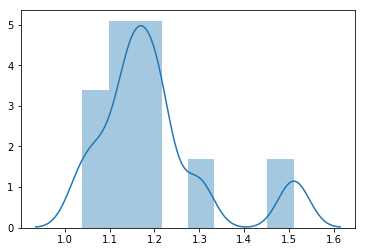

In [19]:
print('Nguyen4')
plot_results([x[0] for x in rv_results[0]])

Nguyen7
mean: 0.014394632596843404
median: 0.0063864819895868615
variance: 0.0003604339548894591
min: 0.001864754467851605


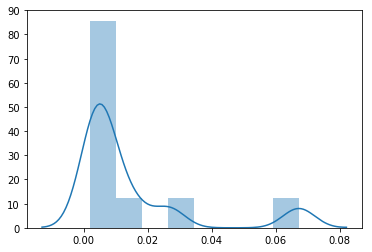

In [20]:
print('Nguyen7')
plot_results([x[0] for x in rv_results[1]])

Nguyen10
mean: 0.03904517507712922
median: 0.03775657825148597
variance: 6.108470116802196e-05
min: 0.027637226127340975


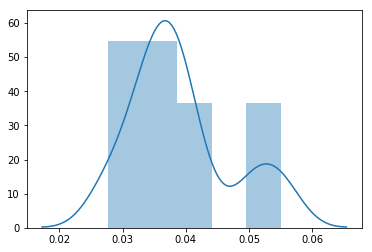

In [21]:
print('Nguyen10')
plot_results([x[0] for x in rv_results[2]])

Korns12
mean: 2.1261776847640923
median: 2.321134298274283
variance: 0.10408162552646552
min: 1.3838449165625466


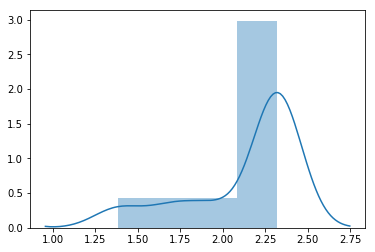

In [22]:
print('Korns12')
plot_results([x[0] for x in rv_results[3]])